# Behavioral Cloning
[Assignment PDF](http://rail.eecs.berkeley.edu/deeprlcourse/static/homeworks/hw1.pdf)

In [1]:
import os
import tensorflow as tf
import keras
import numpy as np
import pickle
import pandas as pd

# Set matplotlib environment
import matplotlib.pyplot as plt
plt.style.use('bmh')
%pylab inline

# Reload python module by default
# https://iqbalnaved.wordpress.com/2013/10/18/ipython-tip-reloading-modified-code/
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys

def add_to_path(new_paths):
    for new_path in paths_to_add:
        if new_path not in sys.path:
            sys.path.append(new_path)


CWD = os.getcwd().replace('/notebooks', '')
os.chdir(CWD)
paths_to_add = [CWD]
add_to_path(paths_to_add)

## 1. Set Up environment with OpenAi Roboschool instead of MuJoCo
In my fork to this homework repository I have added instruction of how to set up the environment with virtualenv or with a prebuild docker image. First setup the environment and then you will be able to run this notebook.

## 2. Behavioral Cloning
The idea behind Behavioral Cloning is to apply Supervised Learning methods in order to learn a control policy. This basically means that we are not going to learn a state/action value function. Instead we will record a set of trajectories/rewards ran by an expert policy and try to imitate that continues action vector policy using a regretion model (in this case, an ANN with a regresion head).


### Generating the dataset

In [3]:
from consts import EXPERT_DIR, ROBOSCOOL_AVAILABLE_ENVS, EXPERT_DATA_DIR
from run_expert import run_expert_policy

In [4]:
#!rm -fr {EXPERT_DATA_DIR}
!mkdir -p {EXPERT_DATA_DIR}

In [18]:
import pickle


for envname in ROBOSCOOL_AVAILABLE_ENVS:
    pickle_filename = os.path.join(EXPERT_DATA_DIR, envname + '.pkl')
    if os.path.isfile(pickle_filename):
        print ("env %s dataset already exists" % envname)
        continue;
                                   
    print("Running env %s" % envname)
    %time expert_data = run_expert_policy(num_rollouts=50, envname=envname, verbose=False)
    with open(pickle_filename, 'wb') as f:
        pickle.dump(expert_data, f, pickle.HIGHEST_PROTOCOL) 

Running env RoboschoolAnt-v1
Env description: Expert policy for module RoboschoolAnt-v1
mean return 1818.8292998516504
std of return 381.8678179633842
CPU times: user 40 s, sys: 1min 3s, total: 1min 43s
Wall time: 1min 44s
Running env RoboschoolHumanoid-v1
Env description: Expert policy for module RoboschoolHumanoid-v1
mean return 2848.910280488764
std of return 1033.9963047075728
CPU times: user 2min 55s, sys: 7min 5s, total: 10min
Wall time: 2min 30s
Running env RoboschoolHalfCheetah-v1
Env description: Expert policy for module RoboschoolHalfCheetah-v1
mean return 2271.29843854231
std of return 909.0033810184069
CPU times: user 25.2 s, sys: 47.3 s, total: 1min 12s
Wall time: 1min 12s
Running env RoboschoolReacher-v1
Env description: Expert policy for module RoboschoolReacher-v1
mean return 18.612237270160552
std of return 10.257759621234174
CPU times: user 1.49 s, sys: 3.15 s, total: 4.64 s
Wall time: 4.67 s
Running env RoboschoolHopper-v1
Env description: Expert policy for module Ro

# Helper modules/functions

## manage_datasets.py: Helper functions for loading the specific domain tasks Datasets
For example, load the train/test datasets with their labels, and show their input and output vectors

In [6]:
from manage_datasets import get_datasets
from consts import EXPERT_DATA_DIR


dataset_name = 'RoboschoolAnt-v1'
X_train, X_test, y_train, y_test = get_datasets(dataset_name=dataset_name, dataset_dir=EXPERT_DATA_DIR)

loading dataset RoboschoolAnt-v1
Domain name: RoboschoolAnt-v1
(45000, 28) (5000, 28) (45000, 8) (5000, 8)


In [7]:
X_train[1, :]

array([-0.12892047, -0.02399238,  0.99971217,  0.35790426,  0.30509418,
        0.058642  ,  0.1139003 , -0.11415579,  0.43144047, -0.75470674,
        1.0087281 , -0.03240158,  0.02628127,  0.6814454 , -0.2858721 ,
        0.01521853, -0.68756235,  0.23606583,  0.5452577 ,  0.26748422,
        0.42372003, -0.5583233 ,  0.58613735,  0.07699564,  0.        ,
        1.        ,  1.        ,  1.        ], dtype=float32)

In [8]:
y_train[0, :]

array([ 1.77629344, -0.11997891, -0.30649464, -1.7593687 ,  0.69761764,
        0.70613533, -0.05471253,  0.07859467])

The 'RoboschoolAnt-v1' domain has 28 input features (floats), and the actions vector (what we are trying to predict) have 8 features (floats)

## keras_helpers/model_helper.py: Helper functions for defining a Fully Connected (FC) new Keras model.
For example lets create a Fully connected network that has the input/output dimensions suitable for 'RoboschoolAnt-v1'

In [9]:
from keras_helpers.model_helper import create_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Define model
config_dict = dict(
    input_dim=len(X_train[1, :]),
    output_dim=len(y_train[1, :]),
    units=100,
    layers = 3,
    l2_reg = 1e-04,
    lr = 1e-03,
    dropout=None,
    use_batchnorm=False)

model = create_model(**config_dict)

Instructions for updating:
Colocations handled automatically by placer.


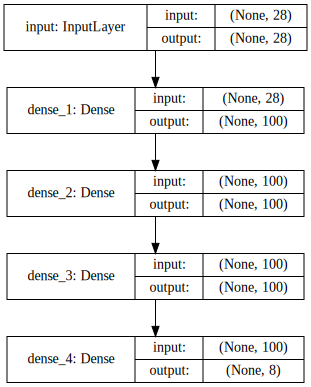

In [10]:
# Plot the model architecture
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

We can easily add dropout and batchnorm layers to this model

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


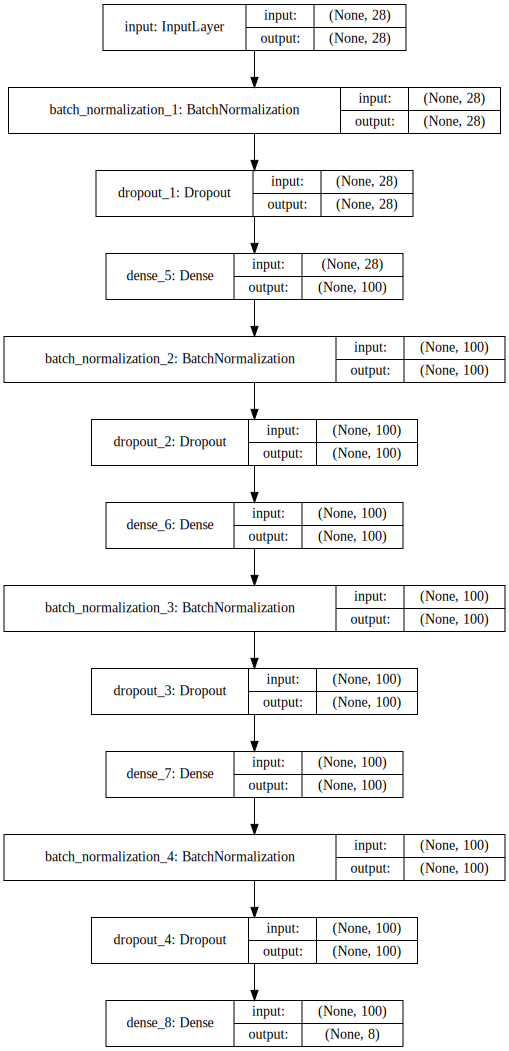

In [11]:
# Define model
config_dict = dict(
    input_dim=len(X_train[1, :]),
    output_dim=len(y_train[1, :]),
    units=100,
    layers = 3,
    l2_reg = 1e-04,
    lr = 1e-03,
    dropout=0.1,
    use_batchnorm=True)

model = create_model(**config_dict)
# Plot the model architecture
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training a FC ANN for each domain
For each domain, we will train an ANN with the same network architecture. I did not perform hyperparameters tunning because it is not the main scope of the task. However, you can try resizing the network or add  regularization/dropout/batchnorm layers in order to improve the loss of each of the networks.

In [15]:
import keras
from keras.callbacks import Callback, LambdaCallback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from manage_datasets import get_datasets
from keras_helpers.model_helper import create_model, get_model_name, calc_mse
from keras_helpers.keras_train_stats import KerasTrainStats
from utils import create_dir_if_not_exists


SAVED_MODELS_DIR = 'models'
MODEL_FILE_NAME = "base.hdf5"
create_dir_if_not_exists(SAVED_MODELS_DIR)

model_mse = []

for envname in ROBOSCOOL_AVAILABLE_ENVS:
    print("Training a FC ANN for env %s" % envname)
    
    # Load the datasets
    X_train, X_test, y_train, y_test = get_datasets(dataset_name=envname, dataset_dir=EXPERT_DATA_DIR)
    
    # Define the model params    
    config_dict = dict(
        input_dim=len(X_train[1, :]),
        output_dim=len(y_train[1, :]),
        units=100,
        layers = 3,
        l2_reg = 1e-04,
        optimizer_cls=keras.optimizers.Adam,
        lr = 1e-03,
        dropout=None,
        use_batchnorm=False)
    
    # Create the model
    model = create_model(**config_dict)
    
    # Compile the model
    optimizer = config_dict['optimizer_cls'](lr=config_dict['lr'])
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    
    # Set a unique name/directory for the model
    model_name = get_model_name(base_name=envname, **config_dict)
    model_path = os.path.join(SAVED_MODELS_DIR, model_name)
    print("model_name='%s'" % model_name)
    print("model_path='%s'" % model_path)
    create_dir_if_not_exists(model_path)
    model_filename = os.path.join(model_path, MODEL_FILE_NAME)
    
    
    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=5, verbose=1)
    tf_board = TensorBoard()

    # Define a train_stats object
    train_stats = KerasTrainStats(model_name=model_name, history_dir=model_path)


    # Train the model
    batch_size = 64
    epochs = 100

    _ = model.fit([X_train], y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[train_stats.print_callback, reduce_lr, tf_board],
        validation_data=([X_test], y_test)
        )
    
    
    # Save the model
    model.save(model_filename)
    print(model_filename)
    
    # Calculate the MSE for each 
    res = calc_mse(model, envname, X_train, X_test, y_train, y_test)
    res['model_name'] = model_name
    res['model_path'] = model_path
    model_mse.append(res)
    print("Done training model for %s" % envname)
    #print("KerasTrainStats(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='%s MSE')" % dataset_name)
    print(res)
    

Training a FC ANN for env RoboschoolAnt-v1
loading dataset RoboschoolAnt-v1
Domain name: RoboschoolAnt-v1
(45000, 28) (5000, 28) (45000, 8) (5000, 8)
model_name='model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm'
model_path='hw1/models/model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm'
Instructions for updating:
Use tf.cast instead.
Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 1s 29us/step - loss: 0.3793 - mean_squared_error: 0.3518 - val_loss: 0.2265 - val_mean_squared_error: 0.1967
Epoch 2/100
45000/45000 [==============================] - 1s 26us/step - loss: 0.1996 - mean_squared_error: 0.1687 - val_loss: 0.1824 - val_mean_squared_error: 0.1508
Epoch 3/100
45000/45000 [==============================] - 1s 30us/step - loss: 0.1665 - mean_squared_error: 0.1345 - val_loss: 0.1583 - val_mean_squared_error: 0

Epoch 44/100
45000/45000 [==============================] - 1s 23us/step - loss: 0.0713 - mean_squared_error: 0.0483 - val_loss: 0.0755 - val_mean_squared_error: 0.0526
Epoch 45/100
45000/45000 [==============================] - 1s 23us/step - loss: 0.0710 - mean_squared_error: 0.0481 - val_loss: 0.0764 - val_mean_squared_error: 0.0536
Epoch 46/100
45000/45000 [==============================] - 1s 23us/step - loss: 0.0707 - mean_squared_error: 0.0479 - val_loss: 0.0758 - val_mean_squared_error: 0.0530
Epoch 47/100
45000/45000 [==============================] - 1s 23us/step - loss: 0.0703 - mean_squared_error: 0.0476 - val_loss: 0.0754 - val_mean_squared_error: 0.0527
Epoch 48/100
45000/45000 [==============================] - 1s 22us/step - loss: 0.0700 - mean_squared_error: 0.0474 - val_loss: 0.0762 - val_mean_squared_error: 0.0536
Epoch 49/100
45000/45000 [==============================] - 1s 23us/step - loss: 0.0699 - mean_squared_error: 0.0474 - val_loss: 0.0748 - val_mean_squared_

45000/45000 [==============================] - 1s 25us/step - loss: 0.0595 - mean_squared_error: 0.0397 - val_loss: 0.0658 - val_mean_squared_error: 0.0459
Epoch 92/100
45000/45000 [==============================] - 1s 23us/step - loss: 0.0594 - mean_squared_error: 0.0396 - val_loss: 0.0655 - val_mean_squared_error: 0.0457
Epoch 93/100
45000/45000 [==============================] - 1s 24us/step - loss: 0.0594 - mean_squared_error: 0.0396 - val_loss: 0.0656 - val_mean_squared_error: 0.0459

Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 94/100
45000/45000 [==============================] - 1s 24us/step - loss: 0.0575 - mean_squared_error: 0.0377 - val_loss: 0.0648 - val_mean_squared_error: 0.0450
Epoch 95/100
45000/45000 [==============================] - 1s 24us/step - loss: 0.0575 - mean_squared_error: 0.0377 - val_loss: 0.0641 - val_mean_squared_error: 0.0444
Epoch 96/100
45000/45000 [==============================] - 2s 39us/step - loss: 0.0574

39654/39654 [==============================] - 1s 25us/step - loss: 0.0264 - mean_squared_error: 0.0176 - val_loss: 0.0259 - val_mean_squared_error: 0.0171
Epoch 34/100
39654/39654 [==============================] - 1s 24us/step - loss: 0.0263 - mean_squared_error: 0.0175 - val_loss: 0.0261 - val_mean_squared_error: 0.0174
Epoch 35/100
39654/39654 [==============================] - 1s 23us/step - loss: 0.0260 - mean_squared_error: 0.0173 - val_loss: 0.0264 - val_mean_squared_error: 0.0177
Epoch 36/100
39654/39654 [==============================] - 1s 23us/step - loss: 0.0260 - mean_squared_error: 0.0173 - val_loss: 0.0266 - val_mean_squared_error: 0.0180
Epoch 37/100
39654/39654 [==============================] - 1s 23us/step - loss: 0.0258 - mean_squared_error: 0.0172 - val_loss: 0.0258 - val_mean_squared_error: 0.0173
Epoch 38/100
39654/39654 [==============================] - 1s 23us/step - loss: 0.0257 - mean_squared_error: 0.0172 - val_loss: 0.0258 - val_mean_squared_error: 0.0173

Epoch 79/100
39654/39654 [==============================] - 1s 29us/step - loss: 0.0211 - mean_squared_error: 0.0131 - val_loss: 0.0217 - val_mean_squared_error: 0.0137
Epoch 80/100
39654/39654 [==============================] - 1s 26us/step - loss: 0.0211 - mean_squared_error: 0.0131 - val_loss: 0.0217 - val_mean_squared_error: 0.0137

Epoch 00080: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 81/100
39654/39654 [==============================] - 1s 29us/step - loss: 0.0211 - mean_squared_error: 0.0131 - val_loss: 0.0217 - val_mean_squared_error: 0.0137
Epoch 82/100
39654/39654 [==============================] - 1s 32us/step - loss: 0.0211 - mean_squared_error: 0.0131 - val_loss: 0.0217 - val_mean_squared_error: 0.0137
Epoch 83/100
39654/39654 [==============================] - 1s 28us/step - loss: 0.0211 - mean_squared_error: 0.0131 - val_loss: 0.0217 - val_mean_squared_error: 0.0137
Epoch 84/100
39654/39654 [==============================] - 1s 30us/step -

38341/38341 [==============================] - 1s 23us/step - loss: 0.0351 - mean_squared_error: 0.0186 - val_loss: 0.0361 - val_mean_squared_error: 0.0198
Epoch 19/100
38341/38341 [==============================] - 1s 23us/step - loss: 0.0349 - mean_squared_error: 0.0186 - val_loss: 0.0366 - val_mean_squared_error: 0.0204
Epoch 20/100
38341/38341 [==============================] - 1s 23us/step - loss: 0.0343 - mean_squared_error: 0.0183 - val_loss: 0.0350 - val_mean_squared_error: 0.0191
Epoch 21/100
38341/38341 [==============================] - 1s 25us/step - loss: 0.0340 - mean_squared_error: 0.0182 - val_loss: 0.0437 - val_mean_squared_error: 0.0280
Epoch 22/100
38341/38341 [==============================] - 1s 23us/step - loss: 0.0340 - mean_squared_error: 0.0183 - val_loss: 0.0367 - val_mean_squared_error: 0.0211
Epoch 23/100
38341/38341 [==============================] - 1s 23us/step - loss: 0.0331 - mean_squared_error: 0.0176 - val_loss: 0.0341 - val_mean_squared_error: 0.0188

Epoch 64/100
38341/38341 [==============================] - 1s 25us/step - loss: 0.0258 - mean_squared_error: 0.0125 - val_loss: 0.0269 - val_mean_squared_error: 0.0136
Epoch 65/100
38341/38341 [==============================] - 1s 23us/step - loss: 0.0258 - mean_squared_error: 0.0125 - val_loss: 0.0269 - val_mean_squared_error: 0.0136
Epoch 66/100
38341/38341 [==============================] - 1s 23us/step - loss: 0.0258 - mean_squared_error: 0.0125 - val_loss: 0.0269 - val_mean_squared_error: 0.0136
Epoch 67/100
38341/38341 [==============================] - 1s 24us/step - loss: 0.0258 - mean_squared_error: 0.0125 - val_loss: 0.0269 - val_mean_squared_error: 0.0136

Epoch 00067: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 68/100
38341/38341 [==============================] - 1s 24us/step - loss: 0.0257 - mean_squared_error: 0.0125 - val_loss: 0.0269 - val_mean_squared_error: 0.0136
Epoch 69/100
38341/38341 [==============================] - 1s 24us/step -

6750/6750 [==============================] - 0s 27us/step - loss: 0.0782 - mean_squared_error: 0.0611 - val_loss: 0.0753 - val_mean_squared_error: 0.0584
Epoch 4/100
6750/6750 [==============================] - 0s 26us/step - loss: 0.0679 - mean_squared_error: 0.0511 - val_loss: 0.0694 - val_mean_squared_error: 0.0526
Epoch 5/100
6750/6750 [==============================] - 0s 25us/step - loss: 0.0584 - mean_squared_error: 0.0416 - val_loss: 0.0620 - val_mean_squared_error: 0.0453
Epoch 6/100
6750/6750 [==============================] - 0s 25us/step - loss: 0.0529 - mean_squared_error: 0.0362 - val_loss: 0.0513 - val_mean_squared_error: 0.0345
Epoch 7/100
6750/6750 [==============================] - 0s 24us/step - loss: 0.0476 - mean_squared_error: 0.0309 - val_loss: 0.0501 - val_mean_squared_error: 0.0334
Epoch 8/100
6750/6750 [==============================] - 0s 24us/step - loss: 0.0436 - mean_squared_error: 0.0269 - val_loss: 0.0432 - val_mean_squared_error: 0.0265
Epoch 9/100
6750

Epoch 51/100
6750/6750 [==============================] - 0s 23us/step - loss: 0.0164 - mean_squared_error: 0.0044 - val_loss: 0.0231 - val_mean_squared_error: 0.0111
Epoch 52/100
6750/6750 [==============================] - 0s 23us/step - loss: 0.0164 - mean_squared_error: 0.0044 - val_loss: 0.0226 - val_mean_squared_error: 0.0107
Epoch 53/100
6750/6750 [==============================] - 0s 23us/step - loss: 0.0163 - mean_squared_error: 0.0043 - val_loss: 0.0226 - val_mean_squared_error: 0.0106
Epoch 54/100
6750/6750 [==============================] - 0s 23us/step - loss: 0.0163 - mean_squared_error: 0.0043 - val_loss: 0.0226 - val_mean_squared_error: 0.0107
Epoch 55/100
6750/6750 [==============================] - 0s 24us/step - loss: 0.0162 - mean_squared_error: 0.0043 - val_loss: 0.0229 - val_mean_squared_error: 0.0110
Epoch 56/100
6750/6750 [==============================] - 0s 24us/step - loss: 0.0162 - mean_squared_error: 0.0043 - val_loss: 0.0228 - val_mean_squared_error: 0.010

6750/6750 [==============================] - 0s 26us/step - loss: 0.0154 - mean_squared_error: 0.0037 - val_loss: 0.0220 - val_mean_squared_error: 0.0103
Epoch 97/100
6750/6750 [==============================] - 0s 24us/step - loss: 0.0154 - mean_squared_error: 0.0037 - val_loss: 0.0220 - val_mean_squared_error: 0.0103
Epoch 98/100
6750/6750 [==============================] - 0s 23us/step - loss: 0.0154 - mean_squared_error: 0.0037 - val_loss: 0.0220 - val_mean_squared_error: 0.0103
Epoch 99/100
6750/6750 [==============================] - 0s 23us/step - loss: 0.0154 - mean_squared_error: 0.0037 - val_loss: 0.0220 - val_mean_squared_error: 0.0103

Epoch 00099: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 100/100
6750/6750 [==============================] - 0s 23us/step - loss: 0.0154 - mean_squared_error: 0.0037 - val_loss: 0.0220 - val_mean_squared_error: 0.0103
hw1/models/model_RoboschoolReacher-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_No

32200/32200 [==============================] - 1s 24us/step - loss: 0.0212 - mean_squared_error: 0.0089 - val_loss: 0.0215 - val_mean_squared_error: 0.0092
Epoch 38/100
32200/32200 [==============================] - 1s 23us/step - loss: 0.0208 - mean_squared_error: 0.0086 - val_loss: 0.0213 - val_mean_squared_error: 0.0091
Epoch 39/100
32200/32200 [==============================] - 1s 24us/step - loss: 0.0212 - mean_squared_error: 0.0091 - val_loss: 0.0217 - val_mean_squared_error: 0.0096
Epoch 40/100
32200/32200 [==============================] - 1s 25us/step - loss: 0.0205 - mean_squared_error: 0.0085 - val_loss: 0.0209 - val_mean_squared_error: 0.0090
Epoch 41/100
32200/32200 [==============================] - 1s 24us/step - loss: 0.0209 - mean_squared_error: 0.0090 - val_loss: 0.0209 - val_mean_squared_error: 0.0090

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 42/100
32200/32200 [==============================] - 1s 24us/step - loss: 0.0191

32200/32200 [==============================] - 1s 25us/step - loss: 0.0168 - mean_squared_error: 0.0057 - val_loss: 0.0176 - val_mean_squared_error: 0.0066
Epoch 83/100
32200/32200 [==============================] - 1s 24us/step - loss: 0.0168 - mean_squared_error: 0.0057 - val_loss: 0.0177 - val_mean_squared_error: 0.0066
Epoch 84/100
32200/32200 [==============================] - 1s 24us/step - loss: 0.0168 - mean_squared_error: 0.0057 - val_loss: 0.0177 - val_mean_squared_error: 0.0066
Epoch 85/100
32200/32200 [==============================] - 1s 24us/step - loss: 0.0168 - mean_squared_error: 0.0057 - val_loss: 0.0177 - val_mean_squared_error: 0.0066
Epoch 86/100
32200/32200 [==============================] - 1s 24us/step - loss: 0.0168 - mean_squared_error: 0.0057 - val_loss: 0.0177 - val_mean_squared_error: 0.0066

Epoch 00086: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 87/100
32200/32200 [==============================] - 1s 27us/step - loss: 0.016

45000/45000 [==============================] - 1s 28us/step - loss: 0.0203 - mean_squared_error: 0.0103 - val_loss: 0.0218 - val_mean_squared_error: 0.0119
Epoch 24/100
45000/45000 [==============================] - 1s 28us/step - loss: 0.0201 - mean_squared_error: 0.0103 - val_loss: 0.0214 - val_mean_squared_error: 0.0116
Epoch 25/100
45000/45000 [==============================] - 1s 28us/step - loss: 0.0199 - mean_squared_error: 0.0102 - val_loss: 0.0220 - val_mean_squared_error: 0.0124

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 26/100
45000/45000 [==============================] - 1s 29us/step - loss: 0.0182 - mean_squared_error: 0.0087 - val_loss: 0.0184 - val_mean_squared_error: 0.0089
Epoch 27/100
45000/45000 [==============================] - 1s 28us/step - loss: 0.0181 - mean_squared_error: 0.0087 - val_loss: 0.0195 - val_mean_squared_error: 0.0101
Epoch 28/100
45000/45000 [==============================] - 1s 28us/step - loss: 0.0180

45000/45000 [==============================] - 1s 28us/step - loss: 0.0140 - mean_squared_error: 0.0059 - val_loss: 0.0145 - val_mean_squared_error: 0.0064
Epoch 70/100
45000/45000 [==============================] - 1s 29us/step - loss: 0.0140 - mean_squared_error: 0.0059 - val_loss: 0.0144 - val_mean_squared_error: 0.0063loss: 0.0140 - mean_squ
Epoch 71/100
45000/45000 [==============================] - 1s 30us/step - loss: 0.0140 - mean_squared_error: 0.0059 - val_loss: 0.0144 - val_mean_squared_error: 0.0063

Epoch 00071: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 72/100
45000/45000 [==============================] - 1s 29us/step - loss: 0.0139 - mean_squared_error: 0.0059 - val_loss: 0.0144 - val_mean_squared_error: 0.0063
Epoch 73/100
45000/45000 [==============================] - 1s 29us/step - loss: 0.0139 - mean_squared_error: 0.0059 - val_loss: 0.0143 - val_mean_squared_error: 0.0063
Epoch 74/100
45000/45000 [==============================] - 1s 

### Show the MSE error on both train/test sets

In [83]:
train_df_stats = pd.DataFrame(model_mse)
train_df_stats[['dataset_name', 'test_mse', 'train_mse']]

,dataset_name,test_mse,train_mse
0,RoboschoolAnt-v1,0.045006,0.037660
1,RoboschoolHumanoid-v1,0.013683,0.013040
2,RoboschoolHalfCheetah-v1,0.013572,0.012406
3,RoboschoolReacher-v1,0.010305,0.003708
4,RoboschoolHopper-v1,0.006560,0.005663
5,RoboschoolWalker2d-v1,0.006229,0.005773


In [84]:
train_df_stats.to_dict("records")

[{'dataset_name': 'RoboschoolAnt-v1',
  'model_name': 'model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm',
  'model_path': 'hw1/models/model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm',
  'test_mse': 0.045005500097009286,
  'train_mse': 0.03765979935236048},
 {'dataset_name': 'RoboschoolHumanoid-v1',
  'model_name': 'model_RoboschoolHumanoid-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm',
  'model_path': 'hw1/models/model_RoboschoolHumanoid-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm',
  'test_mse': 0.013682615999663115,
  'train_mse': 0.013040134573556305},
 {'dataset_name': 'RoboschoolHalfCheetah-v1',
  'model_name': 'model_RoboschoolHalfCheetah-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm',
  'model_path': 'hw1/models/model_RoboschoolHa

## Now lets define a policy based on the models
The files `supervised_model_policy.py` and `run_supervised_policy.py` provide a `SupervisedModelPolicy` class and a method to run each of the new trained policy. It is worth taking a look at them and understand the implementasion.

In [19]:
from run_supervised_policy import run_supervised_model_policy

In [20]:
# Define a mapping between environment name to the model's full path
env_to_model = {i['dataset_name']: os.path.join(i['model_path'], MODEL_FILE_NAME) for i in df.to_dict("records")}
env_to_model

{'RoboschoolAnt-v1': 'hw1/models/model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5',
 'RoboschoolHalfCheetah-v1': 'hw1/models/model_RoboschoolHalfCheetah-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5',
 'RoboschoolHopper-v1': 'hw1/models/model_RoboschoolHopper-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5',
 'RoboschoolHumanoid-v1': 'hw1/models/model_RoboschoolHumanoid-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5',
 'RoboschoolReacher-v1': 'hw1/models/model_RoboschoolReacher-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5',
 'RoboschoolWalker2d-v1': 'hw1/models/model_RoboschoolWalker2d-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5'}

### We can now run the trajectories for each environment based on our model based policies 

In [25]:
SUPERVISED_MODELD_DATA_DIR = 'supervised_modeled_data'
!mkdir -p {SUPERVISED_MODELD_DATA_DIR}
#!rm -rf {SUPERVISED_MODELD_DATA_DIR}

In [29]:
import pickle


for envname in ROBOSCOOL_AVAILABLE_ENVS:
    
    model_filename = env_to_model[envname]
    pickeld_filename = os.path.join(SUPERVISED_MODELD_DATA_DIR, envname + '.pkl')
    if os.path.isfile(pickeld_filename):
        print("Skipping env %s - trajectories already axists" % envname)
        continue
    
    print("Running env %s on supervised modeled data" % envname)
    %time supervised_modeled_data = run_supervised_model_policy(num_rollouts=50, envname=envname, model_filename=model_filename, verbose=False)
    with open(pickeld_filename, 'wb') as f:
        pickle.dump(supervised_modeled_data, f, pickle.HIGHEST_PROTOCOL)
        


Running env RoboschoolAnt-v1 on supervised modeled data


/usr/local/lib/python3.5/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Instructions for updating:
Use tf.cast instead.
Env description: Supervised model policy for module RoboschoolAnt-v1
mean return 1877.2712311909445
std of return 325.90571792640606
CPU times: user 2min 36s, sys: 1min 14s, total: 3min 50s
Wall time: 3min 42s
Running env RoboschoolHumanoid-v1 on supervised modeled data
Env description: Supervised model policy for module RoboschoolHumanoid-v1
mean return 55.859387505426675
std of return 18.571915481313283
CPU times: user 12.9 s, sys: 5.27 s, total: 18.2 s
Wall time: 17.9 s
Running env RoboschoolHalfCheetah-v1 on supervised modeled data
Env description: Supervised model policy for module RoboschoolHalfCheetah-v1
mean return 2262.958939587815
std of return 898.4748019329373
CPU times: user 2min 2s, sys: 57.2 s, total: 2min 59s
Wall time: 2min 53s
Running env RoboschoolReacher-v1 on supervised modeled data
Env description: Supervised model policy for module RoboschoolReacher-v1
mean return 18.13609429203137
std of return 8.195581301095807
CP

In [30]:
!ls {SUPERVISED_MODELD_DATA_DIR}

RoboschoolAnt-v1.pkl	      RoboschoolHumanoid-v1.pkl
RoboschoolHalfCheetah-v1.pkl  RoboschoolReacher-v1.pkl
RoboschoolHopper-v1.pkl       RoboschoolWalker2d-v1.pkl


# Analyze the Model vs Expert performance

### Load the returns for expert/model for each environment

In [34]:
from manage_datasets import load_dataset

returns = {}
for envname in ROBOSCOOL_AVAILABLE_ENVS:
    returns[envname] = {}
    returns[envname]['expert'] = load_dataset(dataset_name=envname, dataset_dir=EXPERT_DATA_DIR)['returns']
    returns[envname]['model'] = load_dataset(dataset_name=envname, dataset_dir=SUPERVISED_MODELD_DATA_DIR)['returns']
    

loading dataset RoboschoolAnt-v1
loading dataset RoboschoolAnt-v1
loading dataset RoboschoolHumanoid-v1
loading dataset RoboschoolHumanoid-v1
loading dataset RoboschoolHalfCheetah-v1
loading dataset RoboschoolHalfCheetah-v1
loading dataset RoboschoolReacher-v1
loading dataset RoboschoolReacher-v1
loading dataset RoboschoolHopper-v1
loading dataset RoboschoolHopper-v1
loading dataset RoboschoolWalker2d-v1
loading dataset RoboschoolWalker2d-v1


### Plot the Expert vs Model returns histograms for each environments 

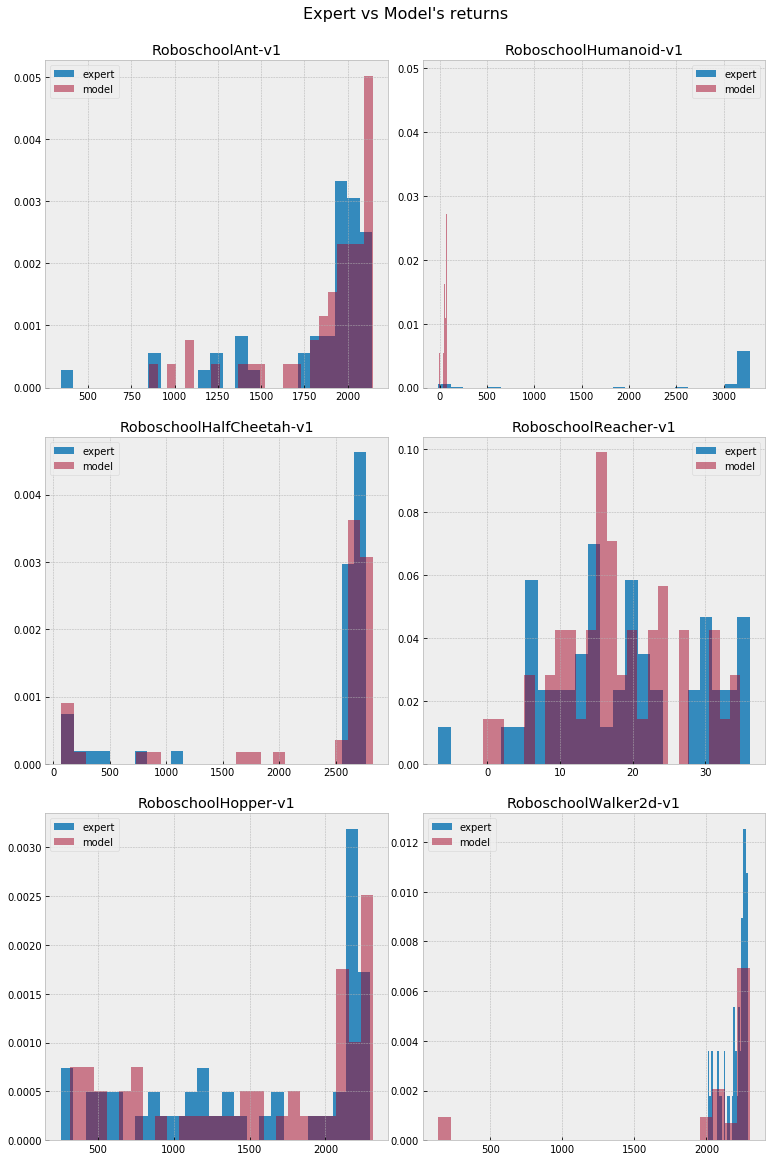

In [39]:
from utils import grid_iterator

fig_title = "Expert vs Model's returns"
density = True # If true, than the histogram's integral sums up to 1

for ax, env_index in grid_iterator(n_rows=3, n_cols=2, axis_size=5, fig_title=fig_title):
    envname = ROBOSCOOL_AVAILABLE_ENVS[env_index]
    ax.hist(returns[envname]['expert'], label='expert', density=density, bins=25)
    ax.hist(returns[envname]['model'], label='model', density=density, bins=25, alpha=0.5)
    ax.set_aspect('auto')
    ax.set_title(envname)
    ax.legend()


## Calculate the stats

In [43]:
from manage_datasets import load_dataset

envs_stats = []
for envname in ROBOSCOOL_AVAILABLE_ENVS:
    expert_data = load_dataset(dataset_name=envname, dataset_dir=EXPERT_DATA_DIR)
    dataset_size = len(expert_data['observations'])
    expert_returns = expert_data['returns']
    model_returns = load_dataset(dataset_name=envname, dataset_dir=SUPERVISED_MODELD_DATA_DIR)['returns']
    
    env_stats = {
        'envname': envname,
        'dataset_size': dataset_size,
        'expert_mean': expert_returns.mean(),
        'expert_std': expert_returns.std(),
        'model_mean': model_returns.mean(),
        'model_std': model_returns.std(),
    }
    envs_stats.append(env_stats)
    

loading dataset RoboschoolAnt-v1
loading dataset RoboschoolAnt-v1
loading dataset RoboschoolHumanoid-v1
loading dataset RoboschoolHumanoid-v1
loading dataset RoboschoolHalfCheetah-v1
loading dataset RoboschoolHalfCheetah-v1
loading dataset RoboschoolReacher-v1
loading dataset RoboschoolReacher-v1
loading dataset RoboschoolHopper-v1
loading dataset RoboschoolHopper-v1
loading dataset RoboschoolWalker2d-v1
loading dataset RoboschoolWalker2d-v1


In [48]:
cols = ['envname', 'dataset_size','expert_mean', 'model_mean', 'expert_std', 'model_std']
stats_df = pd.DataFrame(envs_stats)[cols]
stats_df['model_to_expert'] = stats_df['model_mean'] / stats_df['expert_mean']
stats_df.sort_values(['dataset_size', 'model_to_expert'], ascending=False, inplace=True)

In [49]:
stats_df

,envname,dataset_size,expert_mean,model_mean,expert_std,model_std,model_to_expert
0,RoboschoolAnt-v1,50000,1818.829300,1877.271231,381.867818,325.905718,1.032132
5,RoboschoolWalker2d-v1,50000,2205.412558,2034.656276,81.940065,561.619106,0.922574
1,RoboschoolHumanoid-v1,44060,2803.916301,55.859388,1010.564916,18.571915,0.019922
2,RoboschoolHalfCheetah-v1,42602,2271.298439,2262.958940,909.003381,898.474802,0.996328
4,RoboschoolHopper-v1,35778,1541.857022,1551.511504,687.020552,704.711227,1.006262
3,RoboschoolReacher-v1,7500,18.612237,18.136094,10.257760,8.195581,0.974418


# Comparing RoboschoolAnt-v1 and RoboschoolHumanoid-v1
1. Dataset size: train dataset was about the same size, 45K for the RoboschoolAnt-v1 (90% of 50K) vs 40K for the RoboschoolHumanoid-v1. 
2. Model architecture: the same model arcitecture was used for both tasks: 3 Fully Connected layers with 100 neurons each. L2 regularization of 1e-04 was used with no dropout nor Batch Normalization. 
3. Optimizer, Epochs and Learning rate: both models were trained for 100 epochs with Adam optimizer with initial learning rate of 1e-03. The learning rate was halved after every five cosecutive epochs with no Validation MSE improvement.
4. Performance: for the RoboschoolAnt-v1, the model performance outperformed the expert by ~3.2% (I'm not sure why this is happaning, maybe the trained model implicitly added some sort of required regularization over the expert network...). For the RoboschoolHumanoid-v1 task the model achived less than %2 (~1.9%) of the expert mean reward. For the RoboschoolAnt-v1 task, the return std was also decreased (expert std of ~382, vs model's std of ~307)

## Check RoboschoolAnt-v1 model performance vs train set size
The RoboschoolAnt-v1 model significantly outperformed RoboschoolHumanoid-v1 model's performance against the expert. It would be interesting to see the amount of training data needed in order to reach these performance. Another objective is to validate that the perfomance gap between the two tasks was not couse by the fact that RoboschoolHumanoid-v1 was train on a smaller dataset (45K for RoboschoolAnt-v1 vs 40K for RoboschoolHumanoid-v1).

Note - we will plot the performance in terms of validation loss instead of model_mean/expert_mean in order to avoid running the full 50 trajectories on all training set sizes. In addition, we will report the model_mean/expert_mean specifically for the specific case of training over 40K examples, in order to assure that the performance difference with RoboschoolHumanoid-v1 was not cause by the training set size.


In [78]:
import keras
from keras.callbacks import Callback, LambdaCallback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from manage_datasets import get_datasets
from keras_helpers.model_helper import create_model, get_model_name, calc_mse
from keras_helpers.keras_train_stats import KerasTrainStats


ANT_SAVED_MODELS_DIR = 'ant_models'
MODEL_FILE_NAME = "base.hdf5"
create_dir_if_not_exists(SAVED_MODELS_DIR)

model_mse = []
envname = 'RoboschoolAnt-v1'
# Load the datasets once
X_train, X_test, y_train, y_test = get_datasets(dataset_name=envname, dataset_dir=EXPERT_DATA_DIR)

for train_size in range(10000, 50000, 10000):  # [10000, 20000, 30000, 40000]
    print("Training a FC ANN for env %s over a training set size %d " % (envname, train_size))
    
    # Define the model params   
    config_dict = dict(
        input_dim=len(X_train[1, :]),
        output_dim=len(y_train[1, :]),
        units=100,
        layers = 3,
        l2_reg = 1e-04,
        optimizer_cls=keras.optimizers.Adam,
        lr = 1e-03,
        dropout=None,
        use_batchnorm=False)
    
    # Create the model
    model = create_model(**config_dict)
    
    # Compile the model
    optimizer = config_dict['optimizer_cls'](lr=config_dict['lr'])
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    
    # Set a unique name/directory for the model
    base_name = "%s_training_set_size_%d" % (envname, train_size)
    model_name = get_model_name(base_name=base_name, **config_dict)
    model_path = os.path.join(SAVED_MODELS_DIR, model_name)
    print("model_name='%s'" % model_name)
    print("model_path='%s'" % model_path)
    create_dir_if_not_exists(model_path)
    model_filename = os.path.join(model_path, MODEL_FILE_NAME)
    
    
    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=5, verbose=1)
    tf_board = TensorBoard()

    # Define a train_stats object
    train_stats = KerasTrainStats(model_name=model_name, history_dir=model_path)


    # Train the model
    batch_size = 64
    epochs = 100

    _ = model.fit([X_train[0:train_size]], y_train[0:train_size],
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[train_stats.print_callback, reduce_lr, tf_board],
        validation_data=([X_test], y_test)
        )
    
    # Save the model
    model.save(model_filename)
    print(model_filename)
    
    # Calculate the MSE for each 
    res = calc_mse(model, envname, X_train, X_test, y_train, y_test)
    res['model_name'] = model_name
    res['model_path'] = model_path
    model_mse.append(res)
    print("Done training model for %s" % envname)
    #print("KerasTrainStats(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='%s MSE')" % dataset_name)
    print(res)

loading dataset RoboschoolAnt-v1
Domain name: RoboschoolAnt-v1
(45000, 28) (5000, 28) (45000, 8) (5000, 8)
Training a FC ANN for env RoboschoolAnt-v1 over a training set size 10000 
model_name='model_RoboschoolAnt-v1_training_set_size_10000_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm'
model_path='models/model_RoboschoolAnt-v1_training_set_size_10000_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm'
Train on 10000 samples, validate on 5000 samples
Epoch 1/100
10000/10000 [==============================] - 1s 80us/step - loss: 0.6969 - mean_squared_error: 0.6731 - val_loss: 0.4206 - val_mean_squared_error: 0.3960
Epoch 2/100
10000/10000 [==============================] - 0s 37us/step - loss: 0.3624 - mean_squared_error: 0.3369 - val_loss: 0.3170 - val_mean_squared_error: 0.2906
Epoch 3/100
10000/10000 [==============================] - 0s 39us/step - loss: 0.2811 - mean_squared_error: 0.2538 - val_loss: 0.2623

10000/10000 [==============================] - 0s 35us/step - loss: 0.0955 - mean_squared_error: 0.0647 - val_loss: 0.1161 - val_mean_squared_error: 0.0853
Epoch 46/100
10000/10000 [==============================] - 0s 37us/step - loss: 0.0949 - mean_squared_error: 0.0642 - val_loss: 0.1157 - val_mean_squared_error: 0.0849
Epoch 47/100
10000/10000 [==============================] - 0s 37us/step - loss: 0.0945 - mean_squared_error: 0.0638 - val_loss: 0.1164 - val_mean_squared_error: 0.0857
Epoch 48/100
10000/10000 [==============================] - 0s 40us/step - loss: 0.0947 - mean_squared_error: 0.0641 - val_loss: 0.1179 - val_mean_squared_error: 0.0872

Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 49/100
10000/10000 [==============================] - 0s 38us/step - loss: 0.0920 - mean_squared_error: 0.0614 - val_loss: 0.1124 - val_mean_squared_error: 0.0818
Epoch 50/100
10000/10000 [==============================] - 0s 38us/step - loss: 0.0910

10000/10000 [==============================] - 0s 36us/step - loss: 0.0825 - mean_squared_error: 0.0529 - val_loss: 0.1063 - val_mean_squared_error: 0.0766
Epoch 92/100
10000/10000 [==============================] - 0s 38us/step - loss: 0.0825 - mean_squared_error: 0.0528 - val_loss: 0.1063 - val_mean_squared_error: 0.0766
Epoch 93/100
10000/10000 [==============================] - 0s 40us/step - loss: 0.0825 - mean_squared_error: 0.0528 - val_loss: 0.1062 - val_mean_squared_error: 0.0765
Epoch 94/100
10000/10000 [==============================] - 0s 38us/step - loss: 0.0825 - mean_squared_error: 0.0528 - val_loss: 0.1063 - val_mean_squared_error: 0.0767
Epoch 95/100
10000/10000 [==============================] - 0s 37us/step - loss: 0.0825 - mean_squared_error: 0.0528 - val_loss: 0.1064 - val_mean_squared_error: 0.0767
Epoch 96/100
10000/10000 [==============================] - 0s 39us/step - loss: 0.0824 - mean_squared_error: 0.0527 - val_loss: 0.1062 - val_mean_squared_error: 0.0766

Epoch 33/100
20000/20000 [==============================] - 1s 37us/step - loss: 0.0964 - mean_squared_error: 0.0680 - val_loss: 0.1057 - val_mean_squared_error: 0.0774
Epoch 34/100
20000/20000 [==============================] - 1s 39us/step - loss: 0.0960 - mean_squared_error: 0.0677 - val_loss: 0.1047 - val_mean_squared_error: 0.0765
Epoch 35/100
20000/20000 [==============================] - 1s 36us/step - loss: 0.0952 - mean_squared_error: 0.0670 - val_loss: 0.1027 - val_mean_squared_error: 0.0747
Epoch 36/100
20000/20000 [==============================] - 1s 37us/step - loss: 0.0945 - mean_squared_error: 0.0665 - val_loss: 0.1054 - val_mean_squared_error: 0.0775
Epoch 37/100
20000/20000 [==============================] - 1s 38us/step - loss: 0.0940 - mean_squared_error: 0.0662 - val_loss: 0.1040 - val_mean_squared_error: 0.0762
Epoch 38/100
20000/20000 [==============================] - 1s 37us/step - loss: 0.0936 - mean_squared_error: 0.0659 - val_loss: 0.1022 - val_mean_squared_

20000/20000 [==============================] - 1s 36us/step - loss: 0.0699 - mean_squared_error: 0.0453 - val_loss: 0.0831 - val_mean_squared_error: 0.0586
Epoch 81/100
20000/20000 [==============================] - 1s 33us/step - loss: 0.0697 - mean_squared_error: 0.0452 - val_loss: 0.0825 - val_mean_squared_error: 0.0580
Epoch 82/100
20000/20000 [==============================] - 1s 33us/step - loss: 0.0697 - mean_squared_error: 0.0452 - val_loss: 0.0840 - val_mean_squared_error: 0.0595
Epoch 83/100
20000/20000 [==============================] - 1s 33us/step - loss: 0.0694 - mean_squared_error: 0.0449 - val_loss: 0.0825 - val_mean_squared_error: 0.0580
Epoch 84/100
20000/20000 [==============================] - 1s 36us/step - loss: 0.0694 - mean_squared_error: 0.0450 - val_loss: 0.0836 - val_mean_squared_error: 0.0592
Epoch 85/100
20000/20000 [==============================] - 1s 34us/step - loss: 0.0692 - mean_squared_error: 0.0448 - val_loss: 0.0821 - val_mean_squared_error: 0.0577

30000/30000 [==============================] - 1s 45us/step - loss: 0.0993 - mean_squared_error: 0.0713 - val_loss: 0.1054 - val_mean_squared_error: 0.0775
Epoch 23/100
30000/30000 [==============================] - 1s 35us/step - loss: 0.0980 - mean_squared_error: 0.0702 - val_loss: 0.1012 - val_mean_squared_error: 0.0735
Epoch 24/100
30000/30000 [==============================] - 1s 36us/step - loss: 0.0973 - mean_squared_error: 0.0697 - val_loss: 0.1021 - val_mean_squared_error: 0.0747
Epoch 25/100
30000/30000 [==============================] - 1s 38us/step - loss: 0.0963 - mean_squared_error: 0.0689 - val_loss: 0.1017 - val_mean_squared_error: 0.0744
Epoch 26/100
30000/30000 [==============================] - 1s 35us/step - loss: 0.0956 - mean_squared_error: 0.0684 - val_loss: 0.1001 - val_mean_squared_error: 0.0730
Epoch 27/100
30000/30000 [==============================] - 1s 36us/step - loss: 0.0939 - mean_squared_error: 0.0670 - val_loss: 0.0993 - val_mean_squared_error: 0.0724

30000/30000 [==============================] - 1s 34us/step - loss: 0.0692 - mean_squared_error: 0.0460 - val_loss: 0.0782 - val_mean_squared_error: 0.0551

Epoch 00069: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 70/100
30000/30000 [==============================] - 1s 32us/step - loss: 0.0674 - mean_squared_error: 0.0443 - val_loss: 0.0764 - val_mean_squared_error: 0.0533
Epoch 71/100
30000/30000 [==============================] - 1s 33us/step - loss: 0.0673 - mean_squared_error: 0.0442 - val_loss: 0.0772 - val_mean_squared_error: 0.0541
Epoch 72/100
30000/30000 [==============================] - 1s 32us/step - loss: 0.0673 - mean_squared_error: 0.0442 - val_loss: 0.0771 - val_mean_squared_error: 0.0540
Epoch 73/100
30000/30000 [==============================] - 1s 35us/step - loss: 0.0672 - mean_squared_error: 0.0441 - val_loss: 0.0762 - val_mean_squared_error: 0.0531
Epoch 74/100
30000/30000 [==============================] - 1s 36us/step - loss: 0.0672

40000/40000 [==============================] - 1s 34us/step - loss: 0.1179 - mean_squared_error: 0.0869 - val_loss: 0.1190 - val_mean_squared_error: 0.0881
Epoch 10/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.1142 - mean_squared_error: 0.0836 - val_loss: 0.1125 - val_mean_squared_error: 0.0821
Epoch 11/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.1114 - mean_squared_error: 0.0812 - val_loss: 0.1152 - val_mean_squared_error: 0.0851
Epoch 12/100
40000/40000 [==============================] - 1s 32us/step - loss: 0.1084 - mean_squared_error: 0.0785 - val_loss: 0.1096 - val_mean_squared_error: 0.0799
Epoch 13/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.1065 - mean_squared_error: 0.0770 - val_loss: 0.1073 - val_mean_squared_error: 0.0779
Epoch 14/100
40000/40000 [==============================] - 1s 33us/step - loss: 0.1036 - mean_squared_error: 0.0745 - val_loss: 0.1084 - val_mean_squared_error: 0.0794

40000/40000 [==============================] - 1s 31us/step - loss: 0.0680 - mean_squared_error: 0.0458 - val_loss: 0.0742 - val_mean_squared_error: 0.0521
Epoch 58/100
40000/40000 [==============================] - 1s 29us/step - loss: 0.0678 - mean_squared_error: 0.0458 - val_loss: 0.0737 - val_mean_squared_error: 0.0516
Epoch 59/100
40000/40000 [==============================] - 1s 31us/step - loss: 0.0676 - mean_squared_error: 0.0456 - val_loss: 0.0741 - val_mean_squared_error: 0.0522
Epoch 60/100
40000/40000 [==============================] - 1s 30us/step - loss: 0.0672 - mean_squared_error: 0.0453 - val_loss: 0.0728 - val_mean_squared_error: 0.0509
Epoch 61/100
40000/40000 [==============================] - 1s 30us/step - loss: 0.0671 - mean_squared_error: 0.0452 - val_loss: 0.0744 - val_mean_squared_error: 0.0526
Epoch 62/100
40000/40000 [==============================] - 1s 30us/step - loss: 0.0670 - mean_squared_error: 0.0453 - val_loss: 0.0735 - val_mean_squared_error: 0.0518

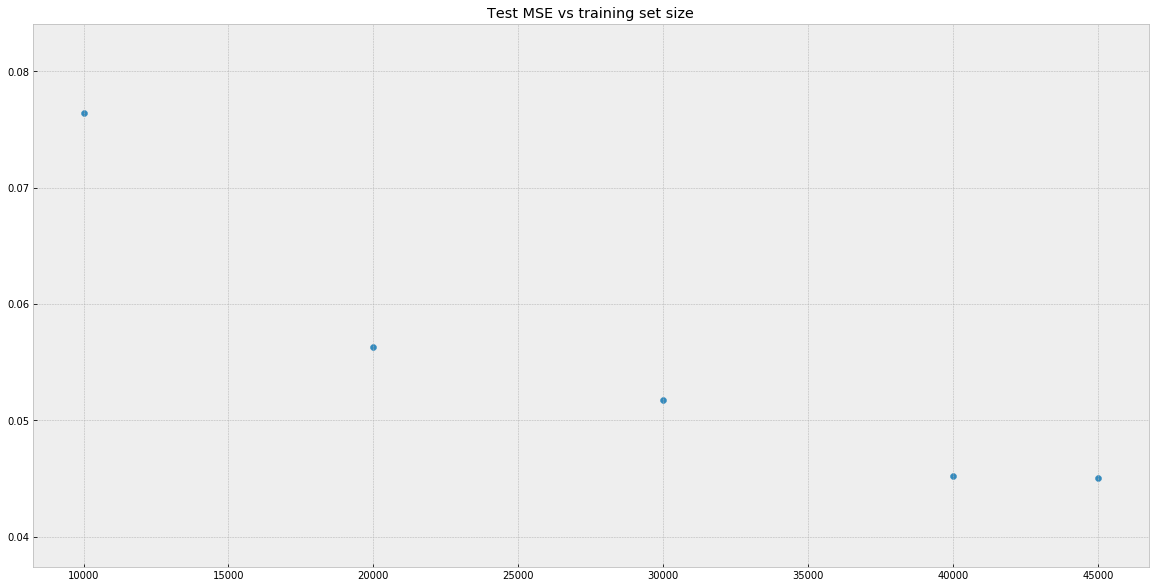

In [88]:
# get the test MSE error for each of the models
roboschool_ant_df = pd.DataFrame(model_mse)
test_mse = roboschool_ant_df['test_mse'].tolist()

# Add the test MSE error we previously got for the training set size of 45K
test_mse_45k = train_df_stats[train_df_stats['dataset_name']=='RoboschoolAnt-v1'].test_mse.iloc[0]
#test_mse_45k = 0.046053225442220666
test_mse.append(test_mse_45k)

# Scatter plot
plt.figure(figsize=(20,10))
scatter(x=[1e+4, 2e+4, 3e+4, 4e+4, 45000], y=test_mse)
_ = plt.title("Test MSE vs training set size")

There is a significant improvement in terms of MSE when increasing the dataset size upto 40K. On the contrary, there seems to be a very subtle performance improvement between 40K and 45K (0.0452 MSE vs 0.045 respectively). We will also calculate the 40K model mean return vs the expert return. 

### Generate the trajectories using the 40K model and compare the results
This is done in order to remove the advantage in number of samples the RoboschoolAnt-v1 model had over thee RoboschoolHumanoid-v1 model

In [97]:
import gym
from run_expert import run_policy

envname = 'RoboschoolAnt-v1'
ant_40k_model_filename = 'models/model_RoboschoolAnt-v1_training_set_size_40000_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5'
policy = SupervisedModelPolicy(envname, model_filename=ant_40k_model_filename)
env = gym.make(envname)
description = "Supervised model policy for module %s with a smaller training set of 40K examples" % envname
%time supervised_modeled_data = run_policy(env=env, policy=policy, num_rollouts=50, \
                                           description=description, verbose=False)

env.close()


/usr/local/lib/python3.5/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Env description: Supervised model policy for module RoboschoolAnt-v1 with a smaller training set of 40K examples
mean return 1819.7226450017135
std of return 359.9117185487721
CPU times: user 2min 43s, sys: 1min 16s, total: 3min 59s
Wall time: 3min 53s


In [115]:
# The calculated returns for the 40K model
returns = supervised_modeled_data['returns']
returns.mean(), returns.std()

(1819.7226450017135, 359.9117185487721)

In [116]:
# The calculated returns for the 45K model
t = stats_df[stats_df['envname'] == 'RoboschoolAnt-v1'][['expert_mean', 'expert_std']].values[0]
prev_mean, prev_std = tuple(t)
prev_mean, prev_std

(1818.8292998516504, 381.8678179633842)

There is no difference in the returns between the 40K and 45K datasets models. This shows that as suspected, the
RoboschoolAnt-v1 model advantage over the RoboschoolHumanoid-v1 model was not caused by the slight different in trainset size.